COMPARING YEAR to YEAR high vs low intensity trades (Must be exact same amount of months compared)

TypeError: no numeric data to plot

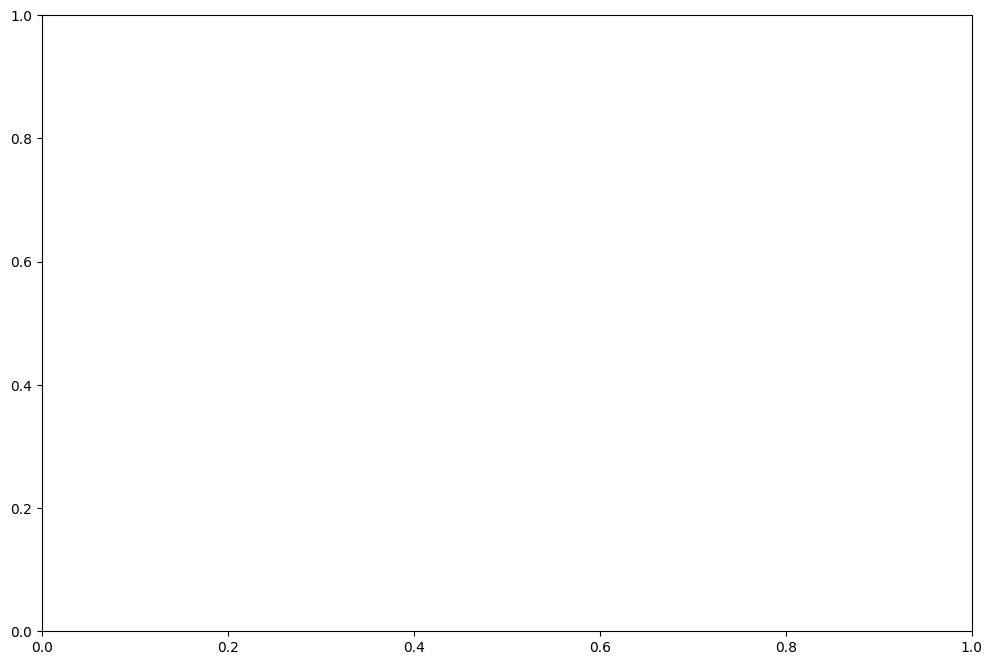

In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.ticker as mticker

# Load the Excel file
file_path = 'input_trade_road.xlsx'
df = pd.read_excel(file_path)
month = "Q1+Q2 2023/2024"

# Exclude rows where either the origin or destination is "N/A"
df = df[(df['Origin Continent'] != 'N/A') & (df['Destination Continent'] != 'N/A')]

# Ensure 'TKm' and 'CO2eq/TKm (g)' are treated as numeric
df['TKm'] = pd.to_numeric(df['TKm'].astype(str).str.replace(',', '').str.replace(' ', ''), errors='coerce')
df['CO2eq/TKm (g)'] = pd.to_numeric(df['CO2eq/TKm (g)'].astype(str).str.replace(',', '').str.replace(' ', ''), errors='coerce')

# Define a function to create the plot for each transport mode
def create_plot_for_transport_mode(df, transport_mode):
    # Filter data for the specific transport mode
    df_mode = df[df['Leg Transport Mode'] == transport_mode]
    
    # Group data by year and continent pairs to calculate total TKm for each pair
    stats_by_pair = df_mode.groupby(['Origin Continent', 'Destination Continent']).agg(
        Total_TKm=('TKm', 'sum'),
        Avg_CO2eq_TKm=('CO2eq/TKm (g)', 'mean')  # Calculate the average CO2eq/TKm for each pair
    ).reset_index()

    # Determine the top 25% threshold for the total TKm
    threshold = stats_by_pair['Total_TKm'].quantile(0)

    # Create a boolean mask for the top 25% continent pairs
    top_25_mask = stats_by_pair['Total_TKm'] > threshold

    # Use loc to avoid SettingWithCopyWarning
    stats_by_pair.loc[top_25_mask, 'Label'] = stats_by_pair.loc[top_25_mask].apply(
        lambda x: f"{x['Origin Continent']} - {x['Destination Continent']} (Avg CO2e: {x['Avg_CO2eq_TKm']:.2f} g/TKm)", axis=1)

    # Merge the label and CO2eq information back to the original dataframe
    df_mode = df_mode.merge(stats_by_pair[['Origin Continent', 'Destination Continent', 'Label', 'Avg_CO2eq_TKm']], 
                            on=['Origin Continent', 'Destination Continent'], 
                            how='left')

    # Filter out rows that didn't get any label (not in the top 25%)
    df_labeled = df_mode[df_mode['Label'].notna()]

    # Group by the new label and service year for plotting
    pivot_data = df_labeled.groupby(['Service Completion Year', 'Label']).agg(
        Total_TKm=('TKm', 'sum')
    ).reset_index()

    # Create a sorted list of labels based on Avg_CO2eq_TKm
    sorted_labels = df_labeled.dropna(subset=['Label']).groupby('Label')['Avg_CO2eq_TKm'].mean().sort_values(ascending=False).index

    # Reorder the pivot table based on sorted labels
    pivot_table = pivot_data.pivot_table(index='Label', columns='Service Completion Year', values='Total_TKm', aggfunc='sum').loc[sorted_labels].fillna(0)

    # Plotting
    fig, ax = plt.subplots(figsize=(12, 8))
    pivot_table.plot(kind='bar', ax=ax, color={2023: 'orange', 2024: '#3200E6'}, width=0.8)
    plt.title(f'Top 25% trade lanes by Total TKm for {month} 2023 and 2024 with Avg CO2e/TKm for {transport_mode}')
    ax.yaxis.set_major_formatter(mticker.ScalarFormatter(useOffset=False))
    fig.patch.set_facecolor('white')
    ax.set_facecolor('white')
    ax.tick_params(colors='#011956')
    ax.xaxis.label.set_color('#011956')
    ax.yaxis.label.set_color('#011956')
    ax.title.set_color('#011956')

    plt.ylabel('Total TKm (in billions)')
    plt.xlabel('Continent Pairs with Avg CO2e/TKm')
    plt.xticks(rotation=45, ha='right')

    # Draw a line to separate high and low CO2eq/Tkm and adjust labels
    median_index = len(pivot_table) // 2
    plt.axvline(x=median_index - 0.5, color='red', linestyle='--')

    # Move the text labels down
    text_position = ax.get_ylim()[1] * 0.8  # Adjust the 0.8 as needed to move the text up or down

    ax.text(median_index - 0.6, text_position, 'Higher CO2e/Tkm', ha='right', va='center', rotation='vertical', color='red', fontsize=9)
    ax.text(median_index - 0.4, text_position, 'Lower CO2e/Tkm', ha='left', va='center', rotation='vertical', color='red', fontsize=9)

    plt.legend(title='Service Completion Year', facecolor='#E9E5E2')
    plt.tight_layout()
    
    # Save the figure
    plt.savefig(f'{transport_mode}_transport_mode_ratio_diagram.png')
    plt.show()

# List of transport modes to create plots for
transport_modes = ['AIR', 'SEA', 'RAI', 'ROA']

# Create a plot for each transport mode
for mode in transport_modes:
    create_plot_for_transport_mode(df, mode)


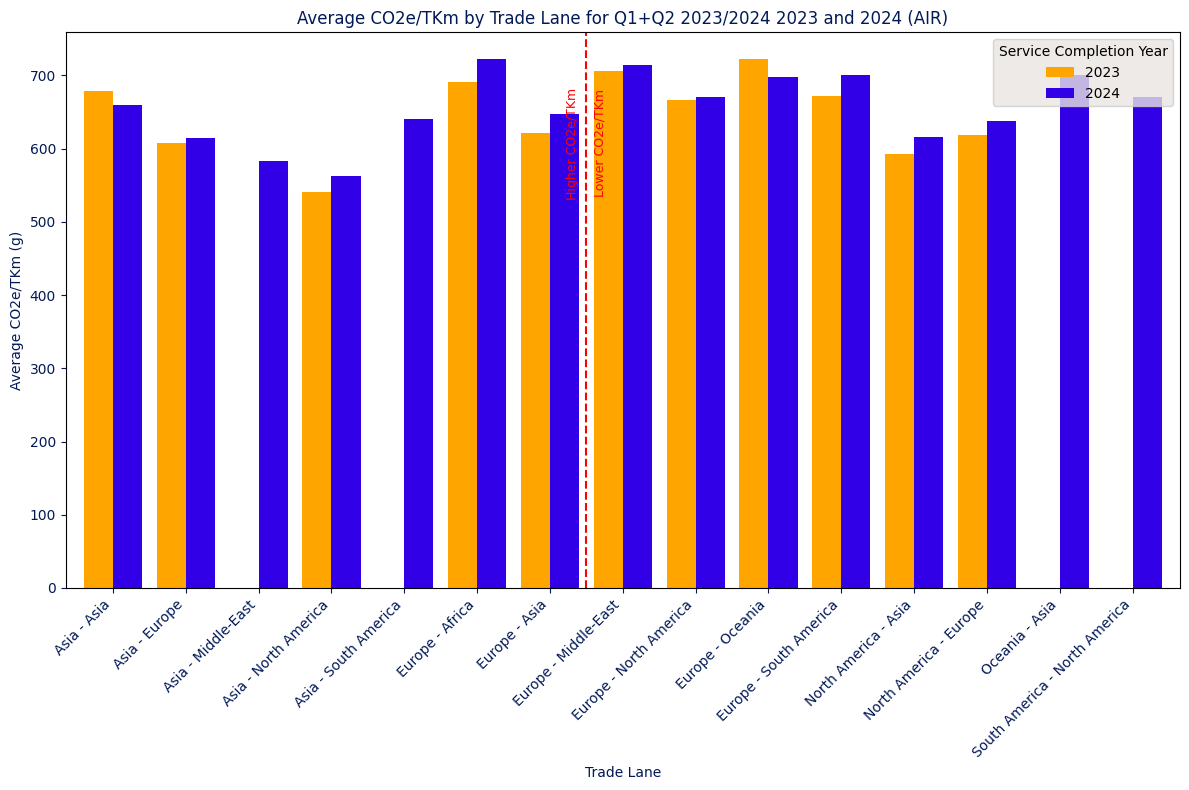

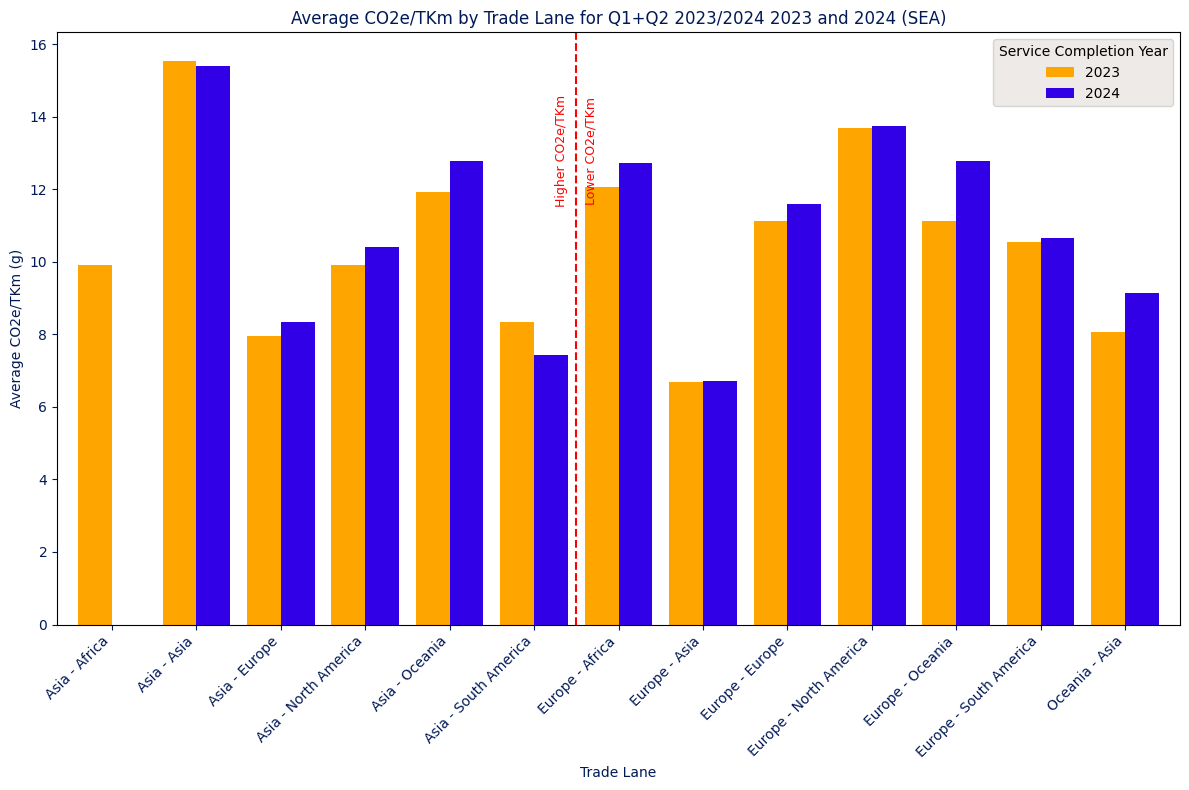

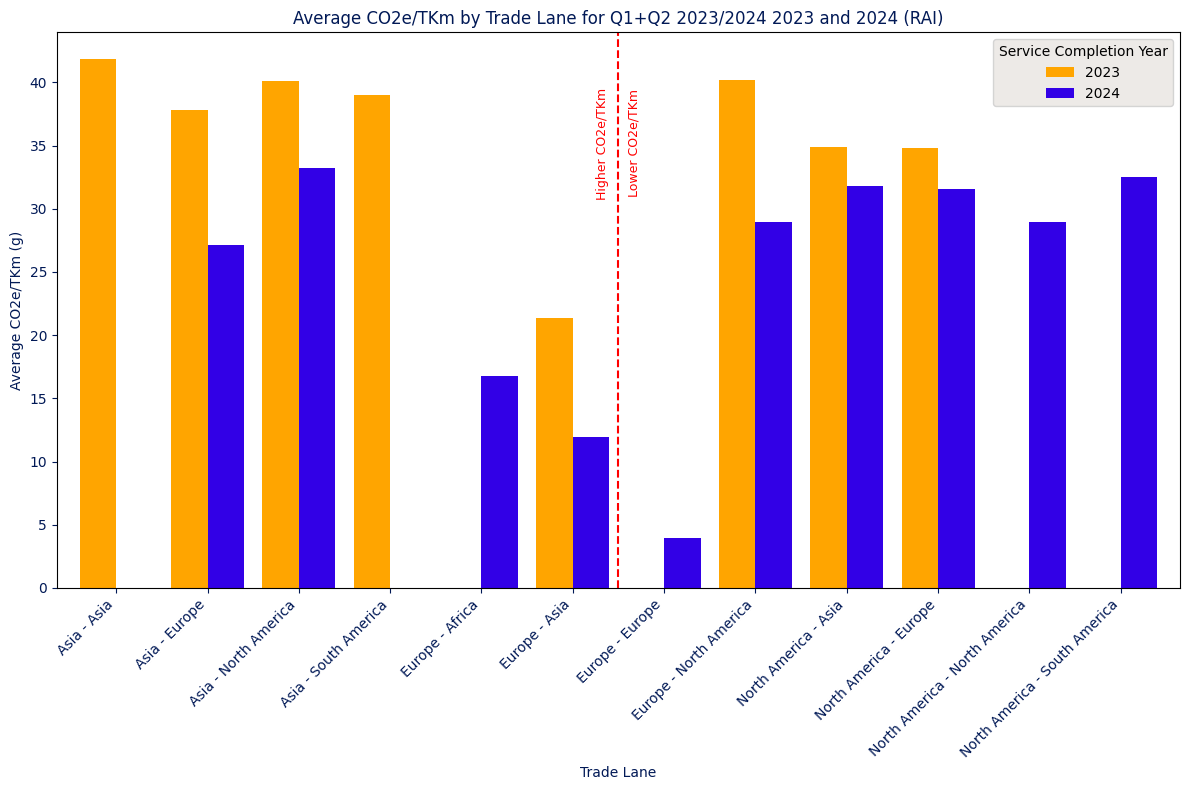

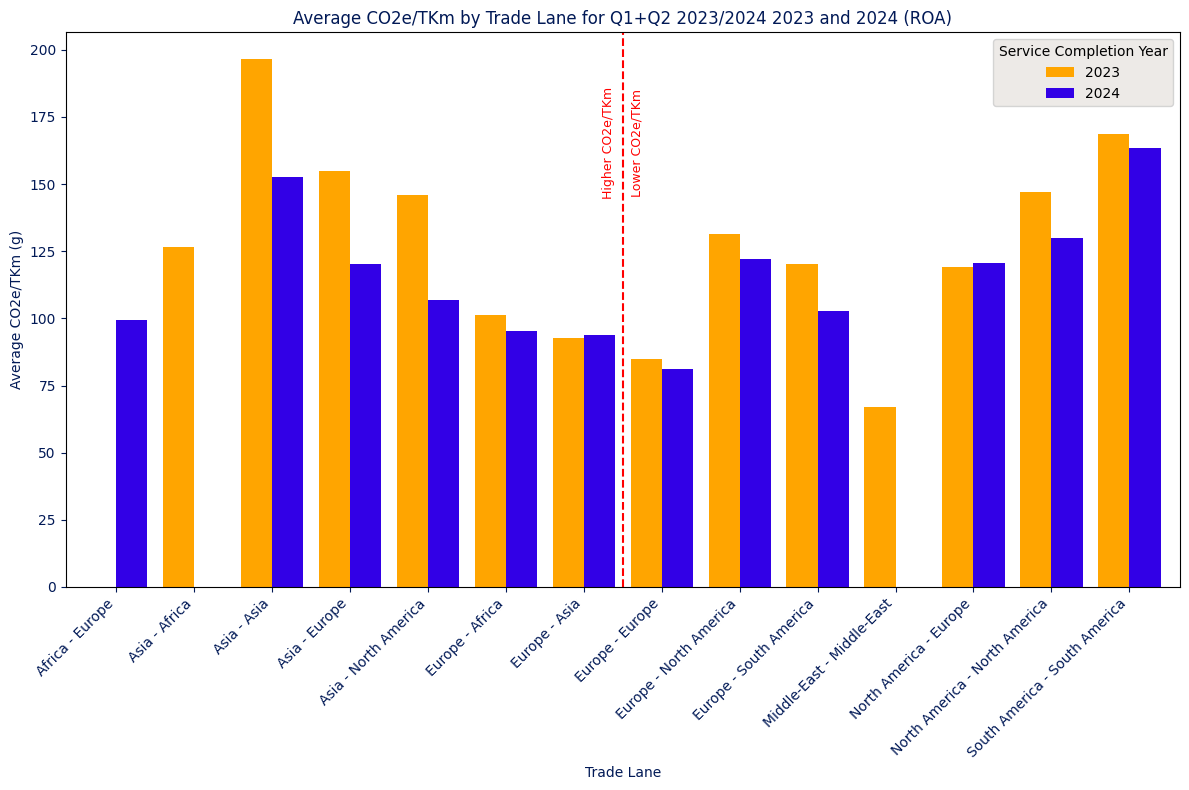

In [16]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.ticker as mticker

# Load the Excel file
file_path = 'input_trade.xlsx'
df = pd.read_excel(file_path)
month = "Q1+Q2 2023/2024"

# Exclude rows where either the origin or destination is "N/A"
df = df[(df['Origin Continent'] != 'N/A') & (df['Destination Continent'] != 'N/A')]

# Ensure 'TKm' and 'CO2eq/TKm (g)' are treated as numeric
df['TKm'] = pd.to_numeric(df['TKm'].astype(str).str.replace(',', '').str.replace(' ', ''), errors='coerce')
df['CO2eq/TKm (g)'] = pd.to_numeric(df['CO2eq/TKm (g)'].astype(str).str.replace(',', '').str.replace(' ', ''), errors='coerce')

# Define a function to create the plot for each transport mode
def create_plot_for_transport_mode(df, transport_mode, quantile_threshold):
    # Filter data for the specific transport mode
    df_mode = df[df['Leg Transport Mode'] == transport_mode]
    
    # Group data by year and continent pairs to calculate average CO2eq/TKm and total TKm for each pair
    stats_by_pair = df_mode.groupby(['Service Completion Year', 'Origin Continent', 'Destination Continent']).agg(
        Avg_CO2eq_TKm=('CO2eq/TKm (g)', 'mean'),
        Total_TKm=('TKm', 'sum')
    ).reset_index()

    # Create a new column for the trade lane
    stats_by_pair['Trade Lane'] = stats_by_pair['Origin Continent'] + ' - ' + stats_by_pair['Destination Continent']

    # Determine the quantile threshold for the total TKm
    threshold = stats_by_pair['Total_TKm'].quantile(quantile_threshold)

    # Filter the lanes based on the quantile threshold
    stats_by_pair = stats_by_pair[stats_by_pair['Total_TKm'] >= threshold]

    # Pivot the table to get years as columns
    pivot_table = stats_by_pair.pivot_table(index='Trade Lane', columns='Service Completion Year', values='Avg_CO2eq_TKm').reset_index()

    # Plotting
    fig, ax = plt.subplots(figsize=(12, 8))
    pivot_table.set_index('Trade Lane').plot(kind='bar', ax=ax, color={2023: 'orange', 2024: '#3200E6'}, width=0.8)
    plt.title(f'Average CO2e/TKm by Trade Lane for {month} 2023 and 2024 ({transport_mode})')
    ax.yaxis.set_major_formatter(mticker.ScalarFormatter(useOffset=False))
    fig.patch.set_facecolor('white')
    ax.set_facecolor('white')
    ax.tick_params(colors='#011956')
    ax.xaxis.label.set_color('#011956')
    ax.yaxis.label.set_color('#011956')
    ax.title.set_color('#011956')

    plt.ylabel('Average CO2e/TKm (g)')
    plt.xlabel('Trade Lane')
    plt.xticks(rotation=45, ha='right')

    # Draw a line to separate high and low CO2eq/TKm and adjust labels
    median_index = len(pivot_table) // 2
    plt.axvline(x=median_index - 0.5, color='red', linestyle='--')

    # Move the text labels down
    text_position = ax.get_ylim()[1] * 0.8  # Adjust the 0.8 as needed to move the text up or down

    ax.text(median_index - 0.6, text_position, 'Higher CO2e/TKm', ha='right', va='center', rotation='vertical', color='red', fontsize=9)
    ax.text(median_index - 0.4, text_position, 'Lower CO2e/TKm', ha='left', va='center', rotation='vertical', color='red', fontsize=9)

    plt.legend(title='Service Completion Year', facecolor='#E9E5E2')
    plt.tight_layout()
    
    # Save the figure
    plt.savefig(f'{transport_mode}_avg_CO2e_TKm_per_trade_lane.png')
    plt.show()

# List of transport modes to create plots for
transport_modes = ['AIR', 'SEA', 'RAI', 'ROA']

# Set the quantile threshold
quantile_threshold = 0.75  # For top 25% lanes

# Create a plot for each transport mode
for mode in transport_modes:
    create_plot_for_transport_mode(df, mode, quantile_threshold)


In [7]:
import pandas as pd

# Load the data
df = pd.read_excel('input_trade.xlsx')

# Ensure 'TKm' and 'CO2eq/TKm (g)' are numeric
df['TKm'] = pd.to_numeric(df['TKm'].astype(str).str.replace(',', '').str.replace(' ', ''), errors='coerce')
df['CO2eq/TKm (g)'] = pd.to_numeric(df['CO2eq/TKm (g)'].astype(str).str.replace(',', '').str.replace(' ', ''), errors='coerce')
df['Total_CO2eq'] = df['TKm'] * df['CO2eq/TKm (g)']

# Define a function to calculate total TKm and total CO2eq for each year
def calculate_totals_by_year(df, year):
    filtered_df = df[df['Service Completion Year'] == year]
    total_TKm = filtered_df['TKm'].sum()
    total_CO2eq = filtered_df['Total_CO2eq'].sum()
    return total_TKm, total_CO2eq

# List of transport modes to evaluate
transport_modes = df['Leg Transport Mode'].unique()

for mode in transport_modes:
    print(f"\nResults for transport mode: {mode}")

    # Filter data for the specific transport mode
    df_mode = df[df['Leg Transport Mode'] == mode]

    # Calculate efficiency for each year
    total_TKm_2023, total_CO2eq_2023 = calculate_totals_by_year(df_mode, 2023)
    total_TKm_2024, total_CO2eq_2024 = calculate_totals_by_year(df_mode, 2024)

    efficiency_2023 = total_CO2eq_2023 / total_TKm_2023
    efficiency_2024 = total_CO2eq_2024 / total_TKm_2024

    # Determine the median CO2eq/TKm for 2023 to classify trade lanes into high and low CO2eq/TKm
    median_CO2eq_2023 = df_mode[df_mode['Service Completion Year'] == 2023]['CO2eq/TKm (g)'].median()

    # Calculate the expected 2024 CO2eq/TKm assuming 2023 trade patterns but applying 2024 efficiency
    # Split 2023 data into high and low CO2eq/TKm lanes
    high_CO2eq_lanes_2023 = df_mode[(df_mode['Service Completion Year'] == 2023) & (df_mode['CO2eq/TKm (g)'] > median_CO2eq_2023)]
    low_CO2eq_lanes_2023 = df_mode[(df_mode['Service Completion Year'] == 2023) & (df_mode['CO2eq/TKm (g)'] <= median_CO2eq_2023)]

    # Calculate the weighted average CO2eq/TKm for high and low lanes in 2024
    high_lanes_CO2eq_2024 = high_CO2eq_lanes_2023['CO2eq/TKm (g)'].mean()
    low_lanes_CO2eq_2024 = low_CO2eq_lanes_2023['CO2eq/TKm (g)'].mean()

    # Estimate the expected 2024 CO2eq using 2023 volumes but 2024 lane efficiencies
    expected_CO2eq_2024 = (high_CO2eq_lanes_2023['TKm'].sum() * high_lanes_CO2eq_2024) + (low_CO2eq_lanes_2023['TKm'].sum() * low_lanes_CO2eq_2024)

    # Calculate the expected 2024 efficiency
    expected_efficiency_2024 = expected_CO2eq_2024 / total_TKm_2024

    # Calculate the percentage difference between actual and expected efficiency
    efficiency_change_pct = ((efficiency_2024 - expected_efficiency_2024) / expected_efficiency_2024) * 100

    print(f"Actual 2024 CO2eq/TKm efficiency: {efficiency_2024:.2f}")
    print(f"Expected 2024 CO2eq/TKm efficiency (assuming 2023 trade patterns): {expected_efficiency_2024:.2f}")
    print(f"Percentage change in CO2eq/TKm efficiency attributed to shifts in trade patterns: {efficiency_change_pct:.2f}%")

    # Corrected Interpretation
    if efficiency_change_pct > 0:
        print("The actual 2024 CO2eq/TKm efficiency is higher than expected, indicating a negative impact from shifts in trade patterns towards less efficient (higher CO2eq/TKm) lanes.")
    else:
        print("The actual 2024 CO2eq/TKm efficiency is lower than expected, indicating a positive impact from shifts in trade patterns towards more efficient (lower CO2eq/TKm) lanes.")



Results for transport mode: AIR
Actual 2024 CO2eq/TKm efficiency: 640.64
Expected 2024 CO2eq/TKm efficiency (assuming 2023 trade patterns): 553.91
Percentage change in CO2eq/TKm efficiency attributed to shifts in trade patterns: 15.66%
The actual 2024 CO2eq/TKm efficiency is higher than expected, indicating a negative impact from shifts in trade patterns towards less efficient (higher CO2eq/TKm) lanes.

Results for transport mode: BRG
Actual 2024 CO2eq/TKm efficiency: 37.63
Expected 2024 CO2eq/TKm efficiency (assuming 2023 trade patterns): 40.59
Percentage change in CO2eq/TKm efficiency attributed to shifts in trade patterns: -7.30%
The actual 2024 CO2eq/TKm efficiency is lower than expected, indicating a positive impact from shifts in trade patterns towards more efficient (lower CO2eq/TKm) lanes.

Results for transport mode: RAI
Actual 2024 CO2eq/TKm efficiency: 21.96
Expected 2024 CO2eq/TKm efficiency (assuming 2023 trade patterns): 25.96
Percentage change in CO2eq/TKm efficiency at

In [10]:
# Correct the interpretation for positive and negative changes
if efficiency_change_pct > 0:
    print("The actual 2024 CO2eq/TKm efficiency is lower than expected, indicating a negative impact from shifts in trade patterns towards less efficient (higher CO2eq/TKm) lanes.")
else:
    print("The actual 2024 CO2eq/TKm efficiency is higher than expected, indicating a positive impact from shifts in trade patterns towards more efficient (lower CO2eq/TKm) lanes.")

# Calculate the total change in CO2eq/TKm efficiency from 2023 to 2024
total_efficiency_change_pct = ((efficiency_2024 - efficiency_2023) / efficiency_2023) * 100

# Calculate the portion of the change not attributed to trade patterns
non_trade_pattern_change = total_efficiency_change_pct - efficiency_change_pct

print(f"Total change in CO2eq/TKm efficiency from 2023 to 2024: {total_efficiency_change_pct:.2f}%")
print(f"Change not attributed to trade patterns: {non_trade_pattern_change:.2f}%")

# Updated Interpretation based on corrected perspective
if efficiency_change_pct < 0:
    # Note: A negative percentage now indicates a decrease in CO2eq/TKm, which is positive in environmental terms
    print("Shifts in trade patterns have contributed to an improvement in CO2eq/TKm efficiency.")
else:
    print("Shifts in trade patterns have contributed to a decrease in CO2eq/TKm efficiency.")


The actual 2024 CO2eq/TKm efficiency is lower than expected, indicating a negative impact from shifts in trade patterns towards less efficient (higher CO2eq/TKm) lanes.
Total change in CO2eq/TKm efficiency from 2023 to 2024: 4.15%
Change not attributed to trade patterns: 2.97%
Shifts in trade patterns have contributed to a decrease in CO2eq/TKm efficiency.


In [7]:
#ROAD ANALYSIS
# extract data from qlik
# run data through the first script to get origin country/continent
# manually add the correct columns, remove missing data and select only relevant period in the excel file
# run in second script

In [1]:
country_continent_mapping = {
    'ad': {'country': 'Andorra', 'continent': 'Europe'}, 
    'ae': {'country': 'United Arab Emirates', 'continent': 'Asia'}, 
    'af': {'country': 'Afghanistan', 'continent': 'Asia'}, 
    'ag': {'country': 'Antigua and Barbuda', 'continent': 'North America'},
    'al': {'country': 'Albania', 'continent': 'Europe'}, 
    'am': {'country': 'Armenia', 'continent': 'Asia'}, 
    'an': {'country': 'Netherlands Antilles', 'continent': 'North America'}, 
    'ao': {'country': 'Angola', 'continent': 'Africa'}, 
    'ar': {'country': 'Argentina', 'continent': 'South America'},
    'at': {'country': 'Austria', 'continent': 'Europe'}, 
    'au': {'country': 'Australia', 'continent': 'Oceania'}, 
    'aw': {'country': 'Aruba', 'continent': 'North America'}, 
    'az': {'country': 'Azerbaijan', 'continent': 'Asia'}, 
    'ba': {'country': 'Bosnia and Herzegovina', 'continent': 'Europe'},
    'bb': {'country': 'Barbados', 'continent': 'North America'}, 
    'bd': {'country': 'Bangladesh', 'continent': 'Asia'}, 
    'be': {'country': 'Belgium', 'continent': 'Europe'}, 
    'bf': {'country': 'Burkina Faso', 'continent': 'Africa'}, 
    'bg': {'country': 'Bulgaria', 'continent': 'Europe'},
    'bh': {'country': 'Bahrain', 'continent': 'Asia'}, 
    'bi': {'country': 'Burundi', 'continent': 'Africa'}, 
    'bj': {'country': 'Benin', 'continent': 'Africa'}, 
    'bl': {'country': 'Saint Barthelemy', 'continent': 'North America'}, 
    'bm': {'country': 'Bermuda', 'continent': 'North America'},
    'bn': {'country': 'Brunei', 'continent': 'Asia'}, 
    'bo': {'country': 'Bolivia', 'continent': 'South America'}, 
    'bq': {'country': 'Bonaire', 'continent': 'North America'}, 
    'br': {'country': 'Brazil', 'continent': 'South America'}, 
    'bs': {'country': 'Bahamas', 'continent': 'North America'}, 
    'bw': {'country': 'Botswana', 'continent': 'Africa'},
    'by': {'country': 'Belarus', 'continent': 'Europe'}, 
    'bz': {'country': 'Belize', 'continent': 'North America'}, 
    'ca': {'country': 'Canada', 'continent': 'North America'}, 
    'cd': {'country': 'Democratic Republic of the Congo', 'continent': 'Africa'},
    'cf': {'country': 'Central African Republic', 'continent': 'Africa'}, 
    'cg': {'country': 'Republic of the Congo', 'continent': 'Africa'}, 
    'ch': {'country': 'Switzerland', 'continent': 'Europe'}, 
    'ci': {'country': 'Ivory Coast', 'continent': 'Africa'}, 
    'ck': {'country': 'Cook Islands', 'continent': 'Oceania'}, 
    'cl': {'country': 'Chile', 'continent': 'South America'},
    'cm': {'country': 'Cameroon', 'continent': 'Africa'}, 
    'cn': {'country': 'China', 'continent': 'Asia'}, 
    'co': {'country': 'Colombia', 'continent': 'South America'}, 
    'cr': {'country': 'Costa Rica', 'continent': 'North America'}, 
    'cu': {'country': 'Cuba', 'continent': 'North America'},
    'cv': {'country': 'Cape Verde', 'continent': 'Africa'}, 
    'cw': {'country': 'Curacao', 'continent': 'North America'}, 
    'cy': {'country': 'Cyprus', 'continent': 'Asia'}, 
    'cz': {'country': 'Czech Republic', 'continent': 'Europe'}, 
    'de': {'country': 'Germany', 'continent': 'Europe'}, 
    'dj': {'country': 'Djibouti', 'continent': 'Africa'},
    'dk': {'country': 'Denmark', 'continent': 'Europe'}, 
    'dm': {'country': 'Dominica', 'continent': 'North America'}, 
    'do': {'country': 'Dominican Republic', 'continent': 'North America'}, 
    'dz': {'country': 'Algeria', 'continent': 'Africa'}, 
    'ec': {'country': 'Ecuador', 'continent': 'South America'},
    'ee': {'country': 'Estonia', 'continent': 'Europe'}, 
    'eg': {'country': 'Egypt', 'continent': 'Africa'}, 
    'es': {'country': 'Spain', 'continent': 'Europe'}, 
    'et': {'country': 'Ethiopia', 'continent': 'Africa'}, 
    'fi': {'country': 'Finland', 'continent': 'Europe'}, 
    'fj': {'country': 'Fiji', 'continent': 'Oceania'},
    'fo': {'country': 'Faroe Islands', 'continent': 'Europe'}, 
    'fr': {'country': 'France', 'continent': 'Europe'}, 
    'FR': {'country': 'France', 'continent': 'Europe'}, 
    'ga': {'country': 'Gabon', 'continent': 'Africa'}, 
    'gb': {'country': 'United Kingdom', 'continent': 'Europe'}, 
    'ge': {'country': 'Georgia', 'continent': 'Asia'},
    'gf': {'country': 'French Guiana', 'continent': 'South America'}, 
    'gh': {'country': 'Ghana', 'continent': 'Africa'}, 
    'gi': {'country': 'Gibraltar', 'continent': 'Europe'}, 
    'gl': {'country': 'Greenland', 'continent': 'North America'}, 
    'gm': {'country': 'Gambia', 'continent': 'Africa'},
    'gn': {'country': 'Guinea', 'continent': 'Africa'}, 
    'gp': {'country': 'Guadeloupe', 'continent': 'North America'}, 
    'gq': {'country': 'Equatorial Guinea', 'continent': 'Africa'}, 
    'gr': {'country': 'Greece', 'continent': 'Europe'}, 
    'gt': {'country': 'Guatemala', 'continent': 'North America'},
    'gu': {'country': 'Guam', 'continent': 'Oceania'}, 
    'gw': {'country': 'Guinea-Bissau', 'continent': 'Africa'}, 
    'gy': {'country': 'Guyana', 'continent': 'South America'}, 
    'hk': {'country': 'Hong Kong', 'continent': 'Asia'}, 
    'hn': {'country': 'Honduras', 'continent': 'North America'},
    'hr': {'country': 'Croatia', 'continent': 'Europe'}, 
    'ht': {'country': 'Haiti', 'continent': 'North America'}, 
    'hu': {'country': 'Hungary', 'continent': 'Europe'}, 
    'id': {'country': 'Indonesia', 'continent': 'Asia'}, 
    'ie': {'country': 'Ireland', 'continent': 'Europe'}, 
    'il': {'country': 'Israel', 'continent': 'Asia'},
    'in': {'country': 'India', 'continent': 'Asia'}, 
    'iq': {'country': 'Iraq', 'continent': 'Asia'}, 
    'ir': {'country': 'Iran', 'continent': 'Asia'}, 
    'is': {'country': 'Iceland', 'continent': 'Europe'}, 
    'it': {'country': 'Italy', 'continent': 'Europe'}, 
    'je': {'country': 'Jersey', 'continent': 'Europe'},
    'jm': {'country': 'Jamaica', 'continent': 'North America'}, 
    'jo': {'country': 'Jordan', 'continent': 'Asia'}, 
    'jp': {'country': 'Japan', 'continent': 'Asia'}, 
    'ke': {'country': 'Kenya', 'continent': 'Africa'}, 
    'kg': {'country': 'Kyrgyzstan', 'continent': 'Asia'}, 
    'kh': {'country': 'Cambodia', 'continent': 'Asia'},
    'km': {'country': 'Comoros', 'continent': 'Africa'}, 
    'kn': {'country': 'Saint Kitts and Nevis', 'continent': 'North America'}, 
    'kr': {'country': 'South Korea', 'continent': 'Asia'}, 
    'kw': {'country': 'Kuwait', 'continent': 'Asia'}, 
    'ky': {'country': 'Cayman Islands', 'continent': 'North America'},
    'kz': {'country': 'Kazakhstan', 'continent': 'Asia'}, 
    'la': {'country': 'Laos', 'continent': 'Asia'}, 
    'lb': {'country': 'Lebanon', 'continent': 'Asia'},  
    'lc': {'country': 'Saint Lucia', 'continent': 'North America'},
    'li': {'country': 'Liechtenstein', 'continent': 'Europe'},
    'lk': {'country': 'Sri Lanka', 'continent': 'Asia'},
    'lr': {'country': 'Liberia', 'continent': 'Africa'},
    'ls': {'country': 'Lesotho', 'continent': 'Africa'},
    'lt': {'country': 'Lithuania', 'continent': 'Europe'},
    'lu': {'country': 'Luxembourg', 'continent': 'Europe'},
    'lv': {'country': 'Latvia', 'continent': 'Europe'},
    'ly': {'country': 'Libya', 'continent': 'Africa'},
    'ma': {'country': 'Morocco', 'continent': 'Africa'},
    'mc': {'country': 'Monaco', 'continent': 'Europe'},
    'md': {'country': 'Moldova', 'continent': 'Europe'},
    'me': {'country': 'Montenegro', 'continent': 'Europe'},
    'mf': {'country': 'Saint Martin', 'continent': 'North America'},
    'mg': {'country': 'Madagascar', 'continent': 'Africa'},
    'mk': {'country': 'North Macedonia', 'continent': 'Europe'},
    'ml': {'country': 'Mali', 'continent': 'Africa'},
    'mm': {'country': 'Myanmar', 'continent': 'Asia'},
    'mn': {'country': 'Mongolia', 'continent': 'Asia'},
    'mo': {'country': 'Macau', 'continent': 'Asia'},
    'mp': {'country': 'Northern Mariana Islands', 'continent': 'Oceania'},
    'mq': {'country': 'Martinique', 'continent': 'North America'},
    'mr': {'country': 'Mauritania', 'continent': 'Africa'},
    'mt': {'country': 'Malta', 'continent': 'Europe'},
    'mu': {'country': 'Mauritius', 'continent': 'Africa'},
    'mv': {'country': 'Maldives', 'continent': 'Asia'},
    'mw': {'country': 'Malawi', 'continent': 'Africa'},
    'mx': {'country': 'Mexico', 'continent': 'North America'},
    'my': {'country': 'Malaysia', 'continent': 'Asia'},
    'mz': {'country': 'Mozambique', 'continent': 'Africa'},
    'na': {'country': 'Namibia', 'continent': 'Africa'},
    'nc': {'country': 'New Caledonia', 'continent': 'Oceania'},
    'ne': {'country': 'Niger', 'continent': 'Africa'},
    'ng': {'country': 'Nigeria', 'continent': 'Africa'},
    'ni': {'country': 'Nicaragua', 'continent': 'North America'},
    'nl': {'country': 'Netherlands', 'continent': 'Europe'},
    'no': {'country': 'Norway', 'continent': 'Europe'},
    'np': {'country': 'Nepal', 'continent': 'Asia'},
    'nz': {'country': 'New Zealand', 'continent': 'Oceania'},
    'om': {'country': 'Oman', 'continent': 'Asia'},
    'pa': {'country': 'Panama', 'continent': 'North America'},
    'pe': {'country': 'Peru', 'continent': 'South America'},
    'pf': {'country': 'French Polynesia', 'continent': 'Oceania'},
    'pg': {'country': 'Papua New Guinea', 'continent': 'Oceania'},
    'ph': {'country': 'Philippines', 'continent': 'Asia'},
    'pk': {'country': 'Pakistan', 'continent': 'Asia'},
    'pl': {'country': 'Poland', 'continent': 'Europe'},
    'pm': {'country': 'Saint Pierre and Miquelon', 'continent': 'North America'},
    'pr': {'country': 'Puerto Rico', 'continent': 'North America'},
    'pt': {'country': 'Portugal', 'continent': 'Europe'},
    'py': {'country': 'Paraguay', 'continent': 'South America'},
    'qa': {'country': 'Qatar', 'continent': 'Asia'},
    're': {'country': 'Reunion', 'continent': 'Africa'},
    'ro': {'country': 'Romania', 'continent': 'Europe'},
    'rs': {'country': 'Serbia', 'continent': 'Europe'},
    'ru': {'country': 'Russia', 'continent': 'Europe'},
    'rw': {'country': 'Rwanda', 'continent': 'Africa'},
    'sa': {'country': 'Saudi Arabia', 'continent': 'Asia'},
    'sc': {'country': 'Seychelles', 'continent': 'Africa'},
    'sd': {'country': 'Sudan', 'continent': 'Africa'},
    'se': {'country': 'Sweden', 'continent': 'Europe'},
    'SE': {'country': 'Sweden', 'continent': 'Europe'},
    'sg': {'country': 'Singapore', 'continent': 'Asia'},
    'si': {'country': 'Slovenia', 'continent': 'Europe'},
    'sj': {'country': 'Svalbard and Jan Mayen', 'continent': 'Europe'},
    'sk': {'country': 'Slovakia', 'continent': 'Europe'},
    'sl': {'country': 'Sierra Leone', 'continent': 'Africa'},
    'sm': {'country': 'San Marino', 'continent': 'Europe'},
    'sn': {'country': 'Senegal', 'continent': 'Africa'},
    'so': {'country': 'Somalia', 'continent': 'Africa'},
    'sr': {'country': 'Suriname', 'continent': 'South America'},
    'st': {'country': 'Sao Tome and Principe', 'continent': 'Africa'},
    'sv': {'country': 'El Salvador', 'continent': 'North America'},
    'sx': {'country': 'Sint Maarten', 'continent': 'North America'},
    'td': {'country': 'Chad', 'continent': 'Africa'},
    'tg': {'country': 'Togo', 'continent': 'Africa'},
    'th': {'country': 'Thailand', 'continent': 'Asia'},
    'tj': {'country': 'Tajikistan', 'continent': 'Asia'},
    'tl': {'country': 'Timor-Leste', 'continent': 'Asia'},
    'tm': {'country': 'Turkmenistan', 'continent': 'Asia'},
    'tn': {'country': 'Tunisia', 'continent': 'Africa'},
    'tr': {'country': 'Turkey', 'continent': 'Asia'},
    'tt': {'country': 'Trinidad and Tobago', 'continent': 'North America'},
    'tw': {'country': 'Taiwan', 'continent': 'Asia'},
    'tz': {'country': 'Tanzania', 'continent': 'Africa'},
    'ua': {'country': 'Ukraine', 'continent': 'Europe'},
    'ug': {'country': 'Uganda', 'continent': 'Africa'},
    'us': {'country': 'United States', 'continent': 'North America'},
    'US': {'country': 'United States', 'continent': 'North America'},
    'uy': {'country': 'Uruguay', 'continent': 'South America'},
    'uz': {'country': 'Uzbekistan', 'continent': 'Asia'},
    'vc': {'country': 'Saint Vincent and the Grenadines', 'continent': 'North America'},
    've': {'country': 'Venezuela', 'continent': 'South America'},
    'vn': {'country': 'Vietnam', 'continent': 'Asia'},
    'vu': {'country': 'Vanuatu', 'continent': 'Oceania'},
    'wf': {'country': 'Wallis and Futuna', 'continent': 'Oceania'},
    'ws': {'country': 'Samoa', 'continent': 'Oceania'},
    'ye': {'country': 'Yemen', 'continent': 'Asia'},
    'yt': {'country': 'Mayotte', 'continent': 'Africa'},
    'za': {'country': 'South Africa', 'continent': 'Africa'},
    'zm': {'country': 'Zambia', 'continent': 'Africa'},
    'zw': {'country': 'Zimbabwe', 'continent': 'Africa'}
}

In [2]:
import pandas as pd

# Load the uploaded Excel file
file_path = 'road_for_pre_proccessing.xlsx'  # Replace with the actual file path
df = pd.read_excel(file_path)

# Extract country codes from the 'Leg Origin Name' column
df['Country Code'] = df['Leg Origin Name'].str.extract(r'\[(\w+)\]')

# Map the country and continent based on the extracted country code
df['Leg Origin Country'] = df['Country Code'].map(lambda code: country_continent_mapping.get(code, {}).get('country'))
df['Leg Origin Continent'] = df['Country Code'].map(lambda code: country_continent_mapping.get(code, {}).get('continent'))

# Save the updated DataFrame to an Excel file
output_file_path = 'input_trade_road.xlsx'
df.to_excel(output_file_path, index=False)

# Display the DataFrame to the user
# import ace_tools as tools; tools.display_dataframe_to_user(name="Updated DataFrame with Country and Continent", dataframe=df)

df.head()


,Service Completion Month,Service Completion Year,Leg Transport Mode,Leg Origin Name,CO2eq/TKm (g),#Shipments,CO2eq (tonnes),Distance,Actual Weight (kg),TKm,Country Code,Leg Origin Country,Leg Origin Continent
0,May,2024,ROA,??,149.426893,4,0.201539,509.603644,10586.62,1348.745032,NaN,None,None
1,Jul,2024,ROA,??,147.018508,4,0.084860,509.603644,4530.62,577.205115,NaN,None,None
2,Aug,2024,ROA,??,147.018508,2,0.034117,254.801822,1821.50,232.060759,NaN,None,None
3,Apr,2024,ROA,??,147.018508,1,0.068827,127.400911,3674.61,468.148662,NaN,None,None
4,Jun,2024,ROA,??,363.633848,1,0.066665,127.400911,1439.00,183.329911,NaN,None,None


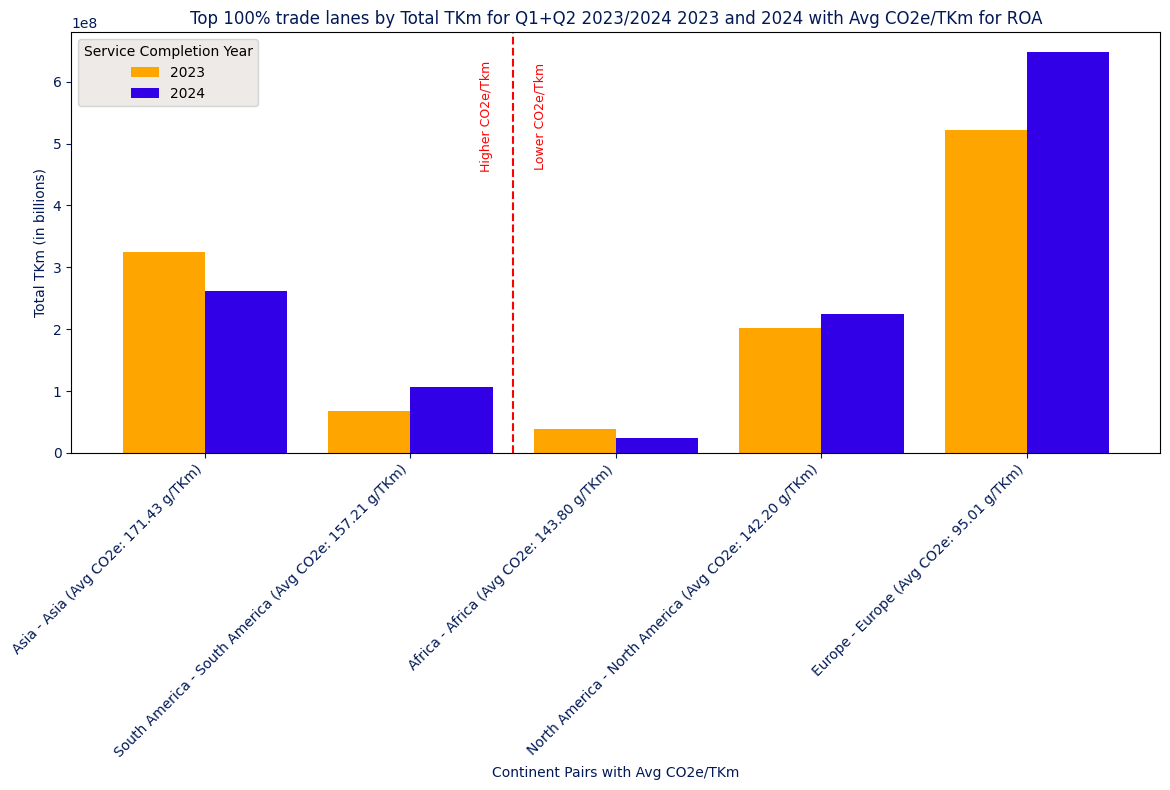

In [12]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker

# Load the Excel file
file_path = 'input_trade_road.xlsx'
df = pd.read_excel(file_path)
month = "Q1+Q2 2023/2024"

# Exclude rows where either the origin or destination is "N/A"
df = df[(df['Origin Continent'] != 'N/A') & (df['Destination Continent'] != 'N/A')]

# Ensure 'TKm' and 'CO2eq/TKm (g)' are treated as numeric
df['TKm'] = pd.to_numeric(df['TKm'].astype(str).str.replace(',', '').str.replace(' ', ''), errors='coerce')
df['CO2eq (tonnes)'] = pd.to_numeric(df['CO2eq (tonnes)'].astype(str).str.replace(',', '').str.replace(' ', ''), errors='coerce')

# Filter data for the specific transport mode
df_mode = df[df['Leg Transport Mode'] == 'ROA']

# Group data by year and continent pairs to calculate total CO2e and TKm for each pair
stats_by_pair = df_mode.groupby(['Origin Continent', 'Destination Continent']).agg(
    Total_TKm=('TKm', 'sum'),
    Total_CO2eq=('CO2eq (tonnes)', 'sum')  # Sum the CO2eq for each pair
).reset_index()

# Calculate the average CO2eq/TKm for each pair based on summed values
stats_by_pair['Avg_CO2eq_TKm'] = (stats_by_pair['Total_CO2eq'] * 1e6) / stats_by_pair['Total_TKm']  # Convert tonnes to grams for CO2eq

# Determine the top 25% threshold for the total TKm
threshold = stats_by_pair['Total_TKm'].quantile(0)

# Create a boolean mask for the top 25% continent pairs
top_25_mask = stats_by_pair['Total_TKm'] > threshold

# Use loc to avoid SettingWithCopyWarning
stats_by_pair.loc[top_25_mask, 'Label'] = stats_by_pair.loc[top_25_mask].apply(
    lambda x: f"{x['Origin Continent']} - {x['Destination Continent']} (Avg CO2e: {x['Avg_CO2eq_TKm']:.2f} g/TKm)", axis=1)

# Merge the label and CO2eq information back to the original dataframe
df_mode = df_mode.merge(stats_by_pair[['Origin Continent', 'Destination Continent', 'Label', 'Avg_CO2eq_TKm']], 
                        on=['Origin Continent', 'Destination Continent'], 
                        how='left')

# Filter out rows that didn't get any label (not in the top 25%)
df_labeled = df_mode[df_mode['Label'].notna()]

# Group by the new label and service year for plotting
pivot_data = df_labeled.groupby(['Service Completion Year', 'Label']).agg(
    Total_TKm=('TKm', 'sum')
).reset_index()

# Create a sorted list of labels based on Avg_CO2eq_TKm
sorted_labels = df_labeled.dropna(subset=['Label']).groupby('Label')['Avg_CO2eq_TKm'].mean().sort_values(ascending=False).index

# Reorder the pivot table based on sorted labels
pivot_table = pivot_data.pivot_table(index='Label', columns='Service Completion Year', values='Total_TKm', aggfunc='sum').loc[sorted_labels].fillna(0)

# Plotting
fig, ax = plt.subplots(figsize=(12, 8))
pivot_table.plot(kind='bar', ax=ax, color={2023: 'orange', 2024: '#3200E6'}, width=0.8)
plt.title(f'Top 100% trade lanes by Total TKm for {month} 2023 and 2024 with Avg CO2e/TKm for ROA')
ax.yaxis.set_major_formatter(mticker.ScalarFormatter(useOffset=False))
fig.patch.set_facecolor('white')
ax.set_facecolor('white')
ax.tick_params(colors='#011956')
ax.xaxis.label.set_color('#011956')
ax.yaxis.label.set_color('#011956')
ax.title.set_color('#011956')

plt.ylabel('Total TKm (in billions)')
plt.xlabel('Continent Pairs with Avg CO2e/TKm')
plt.xticks(rotation=45, ha='right')

# Draw a line to separate high and low CO2eq/Tkm and adjust labels
median_index = len(pivot_table) // 2
plt.axvline(x=median_index - 0.5, color='red', linestyle='--')

# Move the text labels down
text_position = ax.get_ylim()[1] * 0.8  # Adjust the 0.8 as needed to move the text up or down

ax.text(median_index - 0.6, text_position, 'Higher CO2e/Tkm', ha='right', va='center', rotation='vertical', color='red', fontsize=9)
ax.text(median_index - 0.4, text_position, 'Lower CO2e/Tkm', ha='left', va='center', rotation='vertical', color='red', fontsize=9)

plt.legend(title='Service Completion Year', facecolor='#E9E5E2')
plt.tight_layout()

# Save the figure
plt.savefig('ROA_transport_mode_ratio_diagram.png')
plt.show()
